# Timing and profiling matvec_real functions

This code uses the magic functions `%timeit` and `%lprun` <sup> 1 </sup> to measure, respectively, the total and the line-by-line excetution times of the functions `matvec_real_dumb` and `matvec_real_numba`.

* <sup> 1 </sup>[Profiling and Timing Code - excerpt from the Python Data Science Handbook by Jake VanderPlas](https://jakevdp.github.io/PythonDataScienceHandbook/01.07-timing-and-profiling.html)

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import functions as fcs
from tqdm.notebook import tqdm as tq # produce the progress bar

In [2]:
# needed to use the magic function %lprun
%load_ext line_profiler

In [3]:
N = np.array([10, 30, 50, 70, 100, 300, 500, 700, 1000])

In [4]:
list_time_dumb = []
list_time_numba = []
list_time_numpy = []
for Ni in tq(N):
    vector = np.ones(Ni)
    matrix = np.ones((Ni,Ni))
    # matvec_real_dumb
    time = %timeit -o fcs.matvec_real_dumb(matrix, vector)
    list_time_dumb.append(time.average)
    # matvec_real_numba
    time = %timeit -o fcs.matvec_real_numba(matrix, vector)
    list_time_numba.append(time.average)
    # numpy.dot
    time = %timeit -o np.dot(matrix, vector)
    list_time_numpy.append(time.average)

89.2 µs ± 1.06 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
The slowest run took 10.48 times longer than the fastest. This could mean that an intermediate result is being cached.
4.29 µs ± 5.82 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
2.16 µs ± 74.2 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)
813 µs ± 35 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
2.2 µs ± 114 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)
2.4 µs ± 42.5 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)
2.15 ms ± 62.1 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
3.68 µs ± 23.1 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)
2.75 µs ± 25.2 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)
4.13 ms ± 33.1 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
6.11 µs ± 88 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)
3.33 µs ± 16.2 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)
8.32

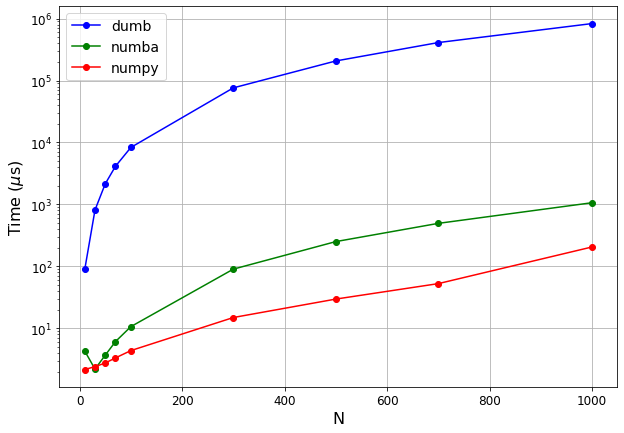

In [5]:
plt.figure(figsize=(10,7))
plt.plot(N, np.asarray(list_time_dumb)*1e6, 'bo-', label = 'dumb')
plt.plot(N, np.asarray(list_time_numba)*1e6, 'go-', label = 'numba')
plt.plot(N, np.asarray(list_time_numpy)*1e6, 'ro-', label = 'numpy')
plt.legend(loc = 'best', fontsize = 14)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.xlabel('N', fontsize = 16)
plt.ylabel('Time ($\mu$s)', fontsize = 16)
plt.yscale('log')
plt.grid()
plt.show()

### line-by-line profiling with `%lprun`

In [6]:
vector = np.ones(500)
matrix = np.ones((500,500))

In [39]:
def matvec_real_dot(A, x):
    result = np.zeros(A.shape[0])
    for i in range(A.shape[0]):
        result[i] = fcs.dot_real_numba(A.real[i], x.real)
    return result

In [9]:
def matvec_real_sum(A, x):
    result = A*x
    result = np.sum(result, axis=1)
    return result

In [10]:
def matvec_real_reduce(A, x):
    result = A*x
    result = np.add.reduce(result, axis=1)
    return result

In [11]:
%timeit np.dot(matrix, vector)

29.8 µs ± 480 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [12]:
%timeit fcs.matvec_real_dumb(matrix, vector)

215 ms ± 2.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [13]:
%timeit fcs.matvec_real_numba(matrix, vector)

261 µs ± 8.84 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [40]:
%timeit matvec_real_dot(matrix, vector)

871 µs ± 5.18 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [15]:
%timeit matvec_real_sum(matrix, vector)

405 µs ± 4.02 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [16]:
%timeit matvec_real_reduce(matrix, vector)

397 µs ± 6.09 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [17]:
%lprun -f fcs.matvec_real_dumb fcs.matvec_real_dumb(matrix, vector)

In [20]:
%lprun -f matvec_real_dot matvec_real_dot(matrix, vector)

In [22]:
%lprun -f matvec_real_sum matvec_real_sum(matrix, vector)

In [23]:
%lprun -f matvec_real_reduce matvec_real_reduce(matrix, vector)

In [24]:
from numba import njit, prange, guvectorize

In [32]:
@njit
def Ax_jit(A, x, res):
    for i in range(A.shape[0]):
        for j in range(A.shape[1]):
            res[i,j] = A.real[i,j]*x.real[j]
    return res

In [26]:
result = np.zeros_like(matrix)

In [27]:
%timeit matrix*vector

286 µs ± 4.88 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [33]:
%timeit Ax_jit(matrix, vector, result)

199 µs ± 3.31 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [34]:
def matvec_real_numba(A, x):
    result = np.empty_like(A)
    result = Ax_jit(A, x, result)
    result = np.add.reduce(result, axis=1)
    return result

In [35]:
%timeit matvec_real_numba(matrix, vector)

329 µs ± 2.99 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [36]:
%lprun -f matvec_real_numba matvec_real_numba(matrix, vector)